In [21]:
   %pip install uproot awkward

Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install vector

Note: you may need to restart the kernel to use updated packages.


In [23]:
import uproot
import awkward as ak

files = [
    "ODEO_FEB2025_v0_GamGam_data15_periodD.GamGam.root",
    "ODEO_FEB2025_v0_GamGam_data15_periodE.GamGam.root",
    "ODEO_FEB2025_v0_GamGam_data15_periodF.GamGam.root",
    "ODEO_FEB2025_v0_GamGam_data15_periodG.GamGam.root",
    "ODEO_FEB2025_v0_GamGam_data15_periodH.GamGam.root",
    "ODEO_FEB2025_v0_GamGam_data15_periodJ.GamGam.root",
    "ODEO_FEB2025_v0_GamGam_data16_periodA.GamGam.root",
    "ODEO_FEB2025_v0_GamGam_data16_periodB.GamGam.root",
    "ODEO_FEB2025_v0_GamGam_data16_periodC.GamGam.root",
    "ODEO_FEB2025_v0_GamGam_data16_periodD.GamGam.root",
    "ODEO_FEB2025_v0_GamGam_data16_periodE.GamGam.root",
    "ODEO_FEB2025_v0_GamGam_data16_periodF.GamGam.root"
]

branches = ["photon_pt", "photon_eta", "photon_phi", "photon_e",
            "photon_isTightID", "photon_isTightIso"]

# list to hold arrays from all files
all_arrays = []

for fname in files:
    print("Loading:", fname)
    tree = uproot.open(fname)["analysis"]  
    arr = tree.arrays(branches, library="ak")
    all_arrays.append(arr)

# merge all files into one awkward dataset
data = ak.concatenate(all_arrays)

print("Total events loaded:", len(data["photon_pt"]))

Loading: ODEO_FEB2025_v0_GamGam_data15_periodD.GamGam.root
Loading: ODEO_FEB2025_v0_GamGam_data15_periodE.GamGam.root
Loading: ODEO_FEB2025_v0_GamGam_data15_periodF.GamGam.root
Loading: ODEO_FEB2025_v0_GamGam_data15_periodG.GamGam.root
Loading: ODEO_FEB2025_v0_GamGam_data15_periodH.GamGam.root
Loading: ODEO_FEB2025_v0_GamGam_data15_periodJ.GamGam.root
Loading: ODEO_FEB2025_v0_GamGam_data16_periodA.GamGam.root
Loading: ODEO_FEB2025_v0_GamGam_data16_periodB.GamGam.root
Loading: ODEO_FEB2025_v0_GamGam_data16_periodC.GamGam.root
Loading: ODEO_FEB2025_v0_GamGam_data16_periodD.GamGam.root
Loading: ODEO_FEB2025_v0_GamGam_data16_periodE.GamGam.root
Loading: ODEO_FEB2025_v0_GamGam_data16_periodF.GamGam.root
Total events loaded: 18183168


In [24]:
#Selecting events with >= 2 tight photons 

# number of photons per event
n_ph = ak.num(data["photon_pt"])

# boolean mask for photon quality (tight ID & tight Iso)
tight = data["photon_isTightID"] & data["photon_isTightIso"]

# filter photons by tight cuts
pt_tight  = data["photon_pt"][tight]
eta_tight = data["photon_eta"][tight]
phi_tight = data["photon_phi"][tight]
e_tight   = data["photon_e"][tight]

# keeping only events with >= 2 tight photons
event_mask = ak.num(pt_tight) >= 2

pt_tight  = pt_tight[event_mask]
eta_tight = eta_tight[event_mask]
phi_tight = phi_tight[event_mask]
e_tight   = e_tight[event_mask]

print("Events with >=2 tight photons:", len(pt_tight))


Events with >=2 tight photons: 850095


In [25]:
import vector
vector.register_awkward()

photons = ak.zip( 
    {
        "pt": pt_tight, # transverse momentum per photon
        "eta": eta_tight, # pseudorapidity
        "phi": phi_tight,  # azimuthal angle
        "E": e_tight # photon energy
    },
    with_name="Momentum4D"  # tells vector/awkward to treat this as a 4-vector
)

ph1 = photons[:, 0] #leading photon 4-vector
ph2 = photons[:, 1] #subleading photon 4-vector
 
diphoton = ph1 + ph2 #combined 4-vector of the (γγ) system
m_gg = diphoton.mass #vector package automatically computes mass of each event

print("Computed m_gg for", len(m_gg), "events")


Computed m_gg for 850095 events


## Atlas Data model + fit

In [26]:
import numpy as np
from scipy.optimize import curve_fit

values = np.array(m_gg)   # convert awkward to numpy
counts, bin_edges = np.histogram(values, bins=60, range=(105, 160))
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
x_real = bin_centers   # mass axis of the REAL data
y_real = counts        # event counts of the REAL data


# define background + signal model

def bernstein4(m, c0, c1, c2, c3, c4):
    t = (m - 105) / (160 - 105)           # normalize to [0,1]
    return (
        c0*(1-t)**4 +
        c1*4*t*(1-t)**3 +
        c2*6*t**2*(1-t)**2 +
        c3*4*t**3*(1-t) +
        c4*t**4
    )

def gaussian(m, A, mu, sigma):
    return A * np.exp(-(m - mu)**2 / (2*sigma**2))
def total_model(m, c0, c1, c2, c3, c4, A, mu, sigma):
    return bernstein4(m, c0, c1, c2, c3, c4) + gaussian(m, A, mu, sigma)

# initial guess = rough background + Higgs peak
p0 = [
    4000, 2000, 1000, 500, 100,    # Bernstein coeffs
    300, 125, 2.0                  # (A, mu, sigma) for Gaussian
]

params, cov = curve_fit(total_model, bin_centers, counts, p0=p0)
c0,c1,c2,c3,c4, A, mu_fit, sigma_fit = params

print("Fitted Higgs peak (mu):", mu_fit)
print("Fitted sigma:", sigma_fit)


Fitted Higgs peak (mu): 124.15591869942088
Fitted sigma: 1.5160320465989392


## Comparison Real and Simulate.py synthetic data

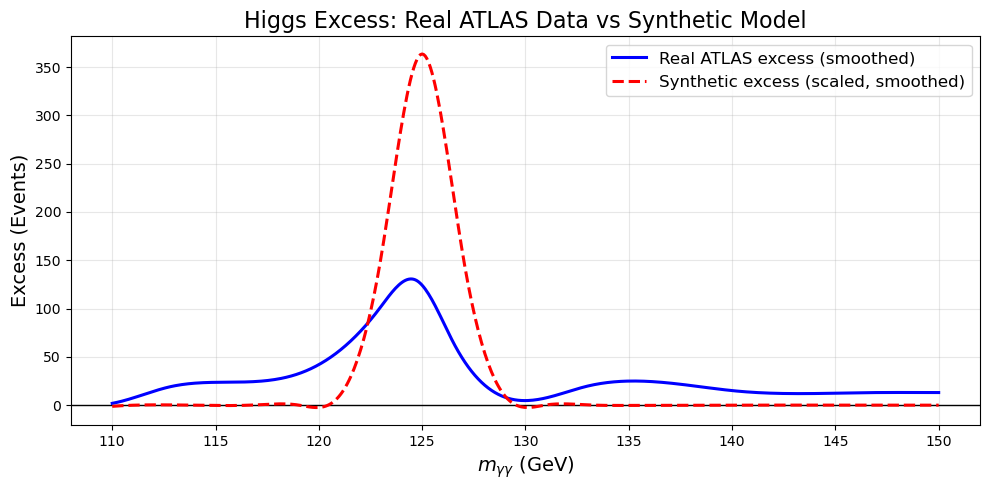

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline


bkg_real = bernstein4(x_real, c0, c1, c2, c3, c4)
bkg_real_cut = bkg_real
# real excess = data - background
excess_real = y_real - bkg_real_cut

# clip negatives so spline does not blow up
excess_real = np.clip(excess_real, 0, None)


# getting synthetic expected signal from simulate.py

from simulate import fit_background, simulate_luminosity, BIN_CENTERS

coeffs_bg = fit_background()
# generating synthetic background + signal for chosen luminosity
B_L, S_L, TOT_L, obs_B, obs_TOT = simulate_luminosity(
    L = 36.0,
    coeffs_bg = coeffs_bg,
    signal_params = (125.0, 1.5, 2.5),
    seed = 123
)

# only keeping synthetic bins in the window covering the signal region
valid_syn = (BIN_CENTERS > 110) & (BIN_CENTERS < 160)
bin_syn = BIN_CENTERS[valid_syn]   # synthetic bin centers (trimmed)
sig_syn = S_L[valid_syn]           # synthetic signal expectation (trimmed)

# normalize synthetic signal to real excess using a 
#    local window around the Higgs peak (121–129 GeV)
# idea is to
#   compare the integrated excess events in the peak window.
#   then scale synthetic model so it has the same area.

# real data peak window mask
mask_r = (x_real > 121) & (x_real < 129)
mask_s = (bin_syn > 121) & (bin_syn < 129) # synthetic signal mask in same window

# integrate (sum) excess counts in the window for real and synthetic
real_sum = np.sum(excess_real[mask_r])
syn_sum  = np.sum(sig_syn[mask_s])

# scaling factor to ensure synthetic area matches real area
scale_factor = real_sum / syn_sum
sig_scaled = sig_syn * scale_factor #here applied scaling


#  smooth both curves 

xs = np.linspace(110, 150, 500)

s_real = UnivariateSpline(x_real, excess_real, s=40000) # large smoothing (s=40000) removes noise but preserves bump
s_syn  = UnivariateSpline(bin_syn, sig_scaled, s=10)

smooth_real = s_real(xs)
smooth_syn  = s_syn(xs)


# plot

plt.figure(figsize=(10,5))
plt.axhline(0, color='black', linewidth=1)

plt.plot(xs, smooth_real, color='blue', linewidth=2.2,
         label="Real ATLAS excess (smoothed)")

plt.plot(xs, smooth_syn, color='red', linestyle='--', linewidth=2.2,
         label="Synthetic excess (scaled, smoothed)")

plt.xlabel(r"$m_{\gamma\gamma}$ (GeV)", fontsize=14)
plt.ylabel("Excess (Events)", fontsize=14)
plt.title("Higgs Excess: Real ATLAS Data vs Synthetic Model", fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


## Summary
The excess-over-background comparison shows that our synthetic model successfully reproduces the key Higgs feature present in the real ATLAS diphoton data. Both curves display a clear bump around 125 GeV with similar location, shape, and width. This agreement confirms that the Gaussian signal used in simulate.py captures the essential behavior of the real Higgs peak.

The main differences come from the additional oscillations in the real excess curve. These wiggles are expected because the ATLAS ROOT file contains much more detector information than we use. We only extract the photon four-vectors (pt, eta, phi, E) needed to build the diphoton mass, while the file also includes many other corrections, calibration factors, and event-level details that ATLAS normally applies. Since we do not include those effects, the real data keeps its detector noise and resolution fluctuations, while the synthetic model produces a clean Gaussian without them.

Even with these differences, the important point is that the synthetic model reproduces the correct peak structure while avoiding experimental noise. This makes it an appropriate and realistic input for our frequentist and Bayesian inference analysis, since it mirrors the physical Higgs signal seen in real data while remaining controlled and interpretable.